# Отчет о проделанной работе

1.  Ячейка 572 - модель, 577 - метрика, 573 - критерий - точность (categorical_accuracy).

2. 569 - использован torchtext, вложения glove.6B.100d 

3. 569 - использован шедулер для управления lr, 576 - график Loss, acc, lr по эпохам. Сравнение графиков потерь и точности на валидации и тестовой выборке показало их близость.

4. Рання остановка (early stopping) реализована вручную: сохраняются веса модели при каждой лучшей валидации. Если после последней лучшей валидации прошло эпох больше E_STOP, то выход. 

7. При использовании готовых вложений: GLOVE-100d с тренировкой точность увеличилась с 74.86% до 78.46%, т.е. почти на 4%. При использовании готовых вложений без тренировки: точность увеличилась до 76.63%, т.е. примерно на 2%. В целом обучение проходит очень быстро, а максимальная точность достигается на 1-2 эпохе.

6. 626 - Валидационная кривая построена для гиперпараметра - начального значения lr. Непрерывных гиперпараметров не так много. Для измерения результатов везде используется точность не на валидационной выборке, а на тестовой (контрольной). Методически это неправильно из-за вероятного переобучения на контрольной выборке, но в данном случае это не важно, зато позволит дать более обоснованные результаты. Графики валидационной и тестовой точности и потерь довольно близки, хотя есть и отличия, обусловленные их размерами. Результат валидационной кривой подтверждает оптимальность значения гиперпараметра lr по умолчанию. Негативный прогноз при завышенном значении гиперпараметра, модель дает плохие результаты при 0.04.

7. Изменение активационной функции на ELU - уменьшило точность на тестовой выборке с 74.86% до 74.25%. Уменьшение составило 0.6% что дает основание отказаться от этого изменения, но требует подтверждения кросс-валидацией.

8. Изменение слоев. Введены дополнительные свертки с ядрами 2, всего 4 свертки с параметрами [2,3,4,5]. Максимальная точность увеличилась до 75.86%, т.е. на 1%. Улучшение нужно подтвердить на кросс-валидации, но его эффект меньше ожидаемого. Добавление нового слоя свертки не дает существенного улучшения точности.

9. Изменение Dropout с 0.5 до 0.1 ухудшило точность с 74.86% до 73.71%, более чем на 1%, что подтверждает его важность.

10. Варианты пулинга (max or average pooling) - изменение на avg_pool1d ухудшило точность с 74.86% до 74.55%. Ухудшение незначительное, но это изменение не рекомендуется.

11. Дополнительные функции: 556 - класс History для накопления метрик. 557 - рисование валидационных графиков. 578 - обучение и оценка. 574 - bb5 - паддинг последовательности токенов - дополнение каждого экземпляра до длины 5. Это необходимо для использования свертки с ядрами  3,4,5.



# Simple CNN
## Readings
1. (torchtext 1) https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-ii-f146c8b9a496
1. (torchtext 2) http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
1. (torchtext 3) http://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/
1. (torchtext 4) http://anie.me/On-Torchtext/
1. (conv 1) https://medium.com/@TalPerry/convolutional-methods-for-text-d5260fd5675f
1. (conv 2) http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/

In [561]:
import pandas as pd
import numpy as np
import time

from sklearn.externals import joblib
import nltk
import gensim
import spacy

from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator

import en_core_web_sm
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

SEED = 42
np.random.seed(SEED)

In [2]:
!head Tweets.csv

tweet_id,airline_sentiment,airline,retweet_count,text
570306133677760513,neutral,Virgin America,0,@VirginAmerica What @dhepburn said.
570301130888122368,positive,Virgin America,0,@VirginAmerica plus you've added commercials to the experience... tacky.
570301083672813571,neutral,Virgin America,0,@VirginAmerica I didn't today... Must mean I need to take another trip!
570301031407624196,negative,Virgin America,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
570300817074462722,negative,Virgin America,0,@VirginAmerica and it's a really big bad thing about it
570300767074181121,negative,Virgin America,0,"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA"
570300616901320704,positive,Virgin America,0,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
570300248553349120,neutral,Virgin America,0,"

# 1 TorchText

In [401]:
#spacy_en = spacy.load('en')

spacy_en = en_core_web_sm.load()

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]            

In [569]:
# dataset

classes={
    'negative':0,
    'neutral':1,
    'positive':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

dataset = TabularDataset('Tweets.csv', format='csv', 
                         fields=[(None, None),('label', LABEL), (None, None),(None, None),('text', TEXT)], 
                         skip_header=True)

# TEXT.build_vocab(dataset, min_freq=10, vectors="glove.6B.100d")
TEXT.build_vocab(dataset, min_freq=5, vectors="glove.6B.100d")

LABEL.build_vocab(dataset)

train, test = dataset.split(stratified=True)
train, valid = train.split(stratified=True)

batch_size = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2676,  0.1054, -0.4203,  ...,  0.4354, -0.2470, -0.6474],
        [ 0.9511, -0.4373,  0.4993,  ...,  0.6739,  0.2300,  0.4647]])

In [651]:
print(pretrained_embeddings.size())

torch.Size([2748, 100])

In [659]:
pretrained_embeddings[3]
TEXT.vocab.vectors.size()

torch.Size([2748, 100])

In [664]:
model.embedding.weight.data

tensor([[ 1.4629, -0.2822,  1.9184,  ...,  0.3143, -1.5849,  0.0409],
        [-0.7172, -0.8726,  0.8488,  ..., -0.7087, -0.5366,  1.2898],
        [-0.1260, -1.7856,  0.2366,  ...,  0.2016, -0.7933, -0.8868],
        ...,
        [ 1.3244, -1.8113, -1.2341,  ...,  0.2655,  1.9538,  0.3970],
        [ 1.0408,  1.0784,  0.8435,  ..., -0.2815,  1.1269, -0.7847],
        [-2.5619,  0.9904,  0.1089,  ..., -1.2230,  0.8071,  0.8892]])

In [648]:
len(TEXT.vocab)

2748

In [463]:
# test

print(len(TEXT.vocab.itos))
print(TEXT.vocab.itos[:10])
[print(s, 'index=', i, 'freq=', TEXT.vocab.freqs[s]) for (i, s) in enumerate(TEXT.vocab.stoi) if i < 10]
print(np.unique([x.label for x in train.examples], return_counts=True))
print(np.unique([x.label for x in valid.examples], return_counts=True))
print(np.unique([x.label for x in test.examples], return_counts=True))
len(valid.examples)
t = valid.examples[1]
print(t.label, t.text)

2748
['<unk>', '<pad>', '<eos>', 'flight', 'get', 'thanks', 'cancelled', 'service', 'help', 'time']
<unk> index= 0 freq= 0
<pad> index= 1 freq= 0
<eos> index= 2 freq= 0
flight index= 3 freq= 3923
get index= 4 freq= 1339
thanks index= 5 freq= 1078
cancelled index= 6 freq= 1065
service index= 7 freq= 967
help index= 8 freq= 868
time index= 9 freq= 793
(array([0, 1, 2]), array([4498, 1518, 1158], dtype=int64))
(array([0, 1, 2]), array([1927,  651,  496], dtype=int64))
(array([0, 1, 2]), array([2753,  930,  709], dtype=int64))
0 ['actual', 'worst', 'zero', 'respect', 'passengers', 'officially', 'done', 'flying']


# 3 Convolutional NN for text classification

Formal definition of convolution of functions $f$ and $g$
$$ (f∗g)(t)= \int_0^{\infty} f(\tau)g(t−\tau) d{\tau} $$

![img](http://www.stokastik.in/wp-content/uploads/2016/09/convolution_ilustration.png)

In [411]:
# Первичная тестовая модель
class MyModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, kernels):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
    def forward(self, x, x_lengths):
        x = self.embedding(x)
        x = x.transpose(1,2)
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x
    
mymodel = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5]
               )    

In [ ]:
###########################################################################

In [677]:
# model

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, 
        #        kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        
        # nn.Conv1d(embed_size, hidden_size, k, padding=5)
        
        self.conv_0 = nn.Conv1d(in_channels=1, out_channels=n_filters, 
                                kernel_size=(filter_sizes[0], embedding_dim))

        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=n_filters, 
                                kernel_size=(filter_sizes[1], embedding_dim))        

        self.conv_2 = nn.Conv1d(in_channels=1, out_channels=n_filters, 
                                kernel_size=(filter_sizes[2], embedding_dim))        
        
        self.conv_3 = nn.Conv1d(in_channels=1, out_channels=n_filters, 
                                kernel_size=(filter_sizes[3], embedding_dim))        

        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, sent len]
        #print('= x size=', x.size())

        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        #print('= embedded size=', embedded.size())
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        #print('= embedded size=', embedded.size())
        
        #conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        conved_3 = F.relu(self.conv_3(embedded).squeeze(3))        
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        #pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #print('= conved size=', conved_0.size())

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)        
        pooled_3 = F.max_pool1d(conved_3, conved_3.shape[2]).squeeze(2)                

        #pooled_n = [batch size, n_filters]        
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2, pooled_3), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4,5]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
print(INPUT_DIM, OUTPUT_DIM)

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, 
                                FILTER_SIZES, OUTPUT_DIM, DROPOUT)

print(model)    


2748 3
CNN(
  (embedding): Embedding(2748, 100)
  (conv_0): Conv1d(1, 100, kernel_size=(2, 100), stride=(1,))
  (conv_1): Conv1d(1, 100, kernel_size=(3, 100), stride=(1,))
  (conv_2): Conv1d(1, 100, kernel_size=(4, 100), stride=(1,))
  (conv_3): Conv1d(1, 100, kernel_size=(5, 100), stride=(1,))
  (fc): Linear(in_features=400, out_features=3, bias=True)
  (dropout): Dropout(p=0.5)
)


In [667]:
#summary(model, input_size=(1, 28, 28))


In [418]:
# Batch - include_lengths=True? = Tensor 
# .text = (list32[list[i]], length[32]) .label=list[32]

print(batch)
print(len(batch), batch.batch_size, batch.dataset, batch.input_fields)
print(batch.label)
print(batch.text[1].size())
print(batch.text[0].size())
print(batch.text[0][:3])
print(batch.text[1][:3])
print(batch.text[1])
print(batch.text[0][:3])
#predictions = model(batch.text[0])
print(predictions[:5])
print(predictions.size())
print(categorical_accuracy(predictions, batch.text[1]))


[torchtext.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.text]:('[torch.LongTensor of size 32x4]', '[torch.LongTensor of size 32]')
32 32 <torchtext.data.dataset.Dataset object at 0x00000082819640B8> ['label', 'text']
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([32])
torch.Size([32, 4])
tensor([[   5, 1216,    0,    2],
        [  61,    3,   18,    2],
        [ 580,   45,   18,    2]])
tensor([4, 4, 4])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])
tensor([[   5, 1216,    0,    2],
        [  61,    3,   18,    2],
        [ 580,   45,   18,    2]])
tensor([[ 0.8738,  0.2182,  0.0176],
        [-0.0460,  0.2540,  0.4414],
        [-0.2822, -0.1102, -0.0072],
        [-0.0477, -0.0714,  0.1592],
        [ 0.3311,  0.4100,  0.2246]], grad_fn=<SliceBackward>)
torch.Size([32, 3])
tensor([0.])


In [441]:
#list(model.parameters())

In [578]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim=1, keepdim=True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum()/torch.FloatTensor([y.shape[0]])

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text = bb5(batch.text[0])
        
        #print(text.size())
        
        predictions = model(text)
        
        loss = criterion(predictions, batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = bb5(batch.text[0])
            predictions = model(text)
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [481]:
batch = list(train_iterator)[1]
predictions = model(bb5(batch.text[0]))
predictions.size()

torch.Size([32, 3])

In [574]:
def bb5(t0):
    s = t0.size()[1]
    if s == 4:
        t0 = F.pad(t0, (0, 1), 'constant', 1)
    elif s == 3:
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)
    elif s == 2:        
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)        
    elif s == 1:        
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)        
        t0 = F.pad(t0, (0, 1), 'constant', 1)                
    return t0


b20 = b2.text[0]
print(b20[:3])
b30 = bb5(b20)
print(b30[:3])
predictions = model(bb5(batch.text[0]))

tensor([[   5, 1216,    0,    2],
        [  61,    3,   18,    2],
        [ 580,   45,   18,    2]])
tensor([[   5, 1216,    0,    2,    1],
        [  61,    3,   18,    2,    1],
        [ 580,   45,   18,    2,    1]])


In [352]:
#v = torch.ones(32,2, dtype=torch.long)
batch = list(test_iterator)[15]
print(batch)
print(batch.text[0][30])



[torchtext.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.text]:('[torch.LongTensor of size 32x4]', '[torch.LongTensor of size 32]')
tensor([ 82, 465, 487,   2])


In [489]:
print(len(test_iterator))
b = list(test_iterator)[15]
b.text

138


(tensor([[   5, 1216,    0,    2],
         [  61,    3,   18,    2],
         [ 580,   45,   18,    2],
         [  47,  400,    0,    2],
         [   5,  338,    3,    2],
         [  22,  204,    0,    2],
         [ 342,  113,   18,    2],
         [  18, 1034,    0,    2],
         [ 421,    0,  698,    2],
         [ 185, 1807,    0,    2],
         [  38,  189,    5,    2],
         [ 203, 1316,  106,    2],
         [ 580,   18,    8,    2],
         [  45,  105,  659,    2],
         [1252,   32,  570,    2],
         [ 658, 1579, 1843,    2],
         [ 227,   18,  175,    2],
         [  82, 2189,    0,    2],
         [  86,   18,    0,    2],
         [ 759,    0,    0,    2],
         [  41, 2190,  494,    2],
         [2239,  339,    5,    2],
         [1990,    5,   82,    2],
         [ 134,  185,    0,    2],
         [  86,  228,  315,    2],
         [  18,   95,  555,    2],
         [ 516,  306,    0,    2],
         [ 128,  417, 1585,    2],
         [   5,   61

In [423]:
print(TEXT.vocab.itos[406])
print(TEXT.vocab.itos[223])
print(TEXT.vocab.itos[427])
print(TEXT.vocab.itos[2695])
print(TEXT.vocab.itos[1619])
print(TEXT.vocab.itos[0])
print(TEXT.vocab.itos[1])
print(TEXT.vocab.itos[2])

print(TEXT.vocab.itos[2712])
print(TEXT.vocab.itos[61])
print(TEXT.vocab.itos[846])

given
answer
mean
smiling
false
<unk>
<pad>
<eos>
thinks
good
cs


In [482]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')    

| Test Loss: 1.253 | Test Acc: 20.22% |


In [584]:
DROPOUT

0.5

In [678]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2676,  0.1054, -0.4203,  ...,  0.4354, -0.2470, -0.6474],
        [ 0.9511, -0.4373,  0.4993,  ...,  0.6739,  0.2300,  0.4647]])

In [679]:
model.embedding.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2676,  0.1054, -0.4203,  ...,  0.4354, -0.2470, -0.6474],
        [ 0.9511, -0.4373,  0.4993,  ...,  0.6739,  0.2300,  0.4647]])

In [680]:
# freeze embedding
model.embedding.weight.requires_grad=False

| Epoch: 01 | Train Loss: 0.713 | Train Acc: 70.47% | Val. Loss: 0.610 | Val. Acc: 75.32% |
| Test Loss: 0.609 | Test Acc: 75.18% |
epoch=0 elapsed=7.066220760345459 lr=0.001
new min_loss, save model, epoch= 0
| Epoch: 02 | Train Loss: 0.571 | Train Acc: 76.62% | Val. Loss: 0.594 | Val. Acc: 75.64% |
| Test Loss: 0.591 | Test Acc: 75.95% |
epoch=1 elapsed=6.782712697982788 lr=0.001
new min_loss, save model, epoch= 1
| Epoch: 03 | Train Loss: 0.518 | Train Acc: 78.75% | Val. Loss: 0.603 | Val. Acc: 75.42% |
| Test Loss: 0.585 | Test Acc: 76.86% |
epoch=2 elapsed=6.5686140060424805 lr=0.001
| Epoch: 04 | Train Loss: 0.464 | Train Acc: 81.20% | Val. Loss: 0.587 | Val. Acc: 75.77% |
| Test Loss: 0.577 | Test Acc: 76.52% |
epoch=3 elapsed=6.6820173263549805 lr=0.001
new min_loss, save model, epoch= 3
| Epoch: 05 | Train Loss: 0.417 | Train Acc: 83.25% | Val. Loss: 0.627 | Val. Acc: 75.61% |
| Test Loss: 0.610 | Test Acc: 76.36% |
epoch=4 elapsed=6.6077189445495605 lr=0.001
| Epoch: 06 | Tra

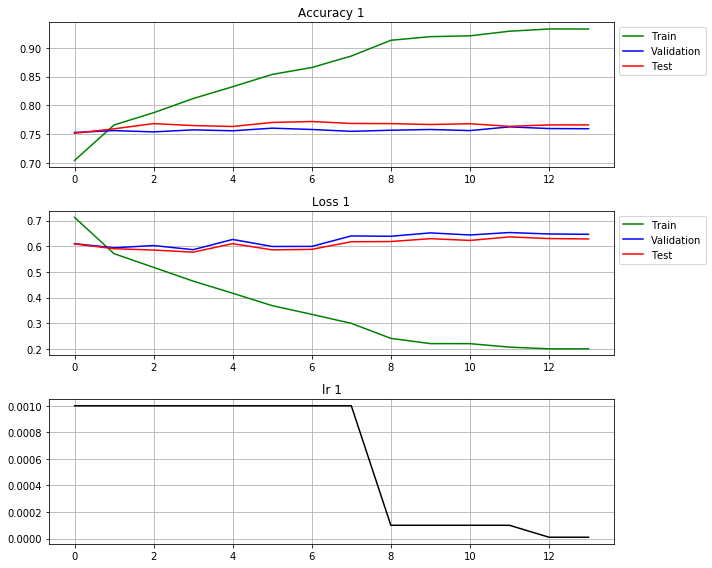

In [681]:
N_EPOCHS = 20
E_STOP = 10
min_loss = 100;

optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

criterion = nn.CrossEntropyLoss()
#cheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

hist = History()

for epoch in range(N_EPOCHS):

    start = time.time()        

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
    
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    
    print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')  
    hist.add_acc(train_acc, valid_acc, test_acc)
    hist.add_loss(train_loss, valid_loss, test_loss)
    
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    hist.add_lr(lr)
    
    end = time.time()   
    elapsed = end - start
    print(f"epoch={epoch} elapsed={elapsed} lr={lr}")
    
    scheduler.step(valid_loss)
    
    if valid_loss < min_loss:
        min_loss = valid_loss
        print('new min_loss, save model, epoch=', epoch)
        e_stop = 1
        # save model+weights
        #torch.save(model.state_dict(), "1.model")
    else:
        e_stop += 1

    if e_stop > E_STOP:
        break
        

aa = np.array(hist.history["test_acc"])
i = np.argmax(aa)
acc = aa[i]
print(i, 'max test_acc=', acc)
        
plt2(hist, '1')

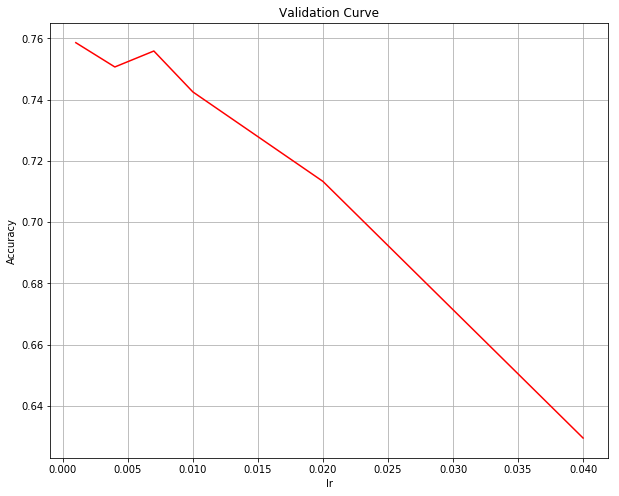

In [637]:
xx = [0.001, 0.004, 0.007, 0.01, 0.02, 0.04]
yy = [0.7586050724637681, 0.7506793478260869, 0.7558876811594203, 0.7425271739130435, 
      0.7133152173913043, 0.6295289855072463]
plt.plot(xx,yy, color="r")
plt.grid()
plt.title("Validation Curve")
plt.xlabel("lr")
plt.ylabel("Accuracy")
plt.show()


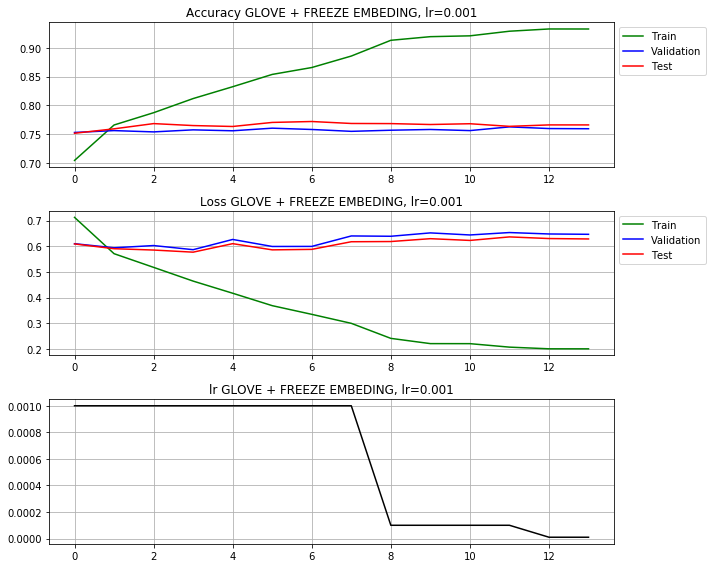

In [682]:
g002 = hist
plt2(g002, 'GLOVE + FREEZE EMBEDING, lr=0.001')

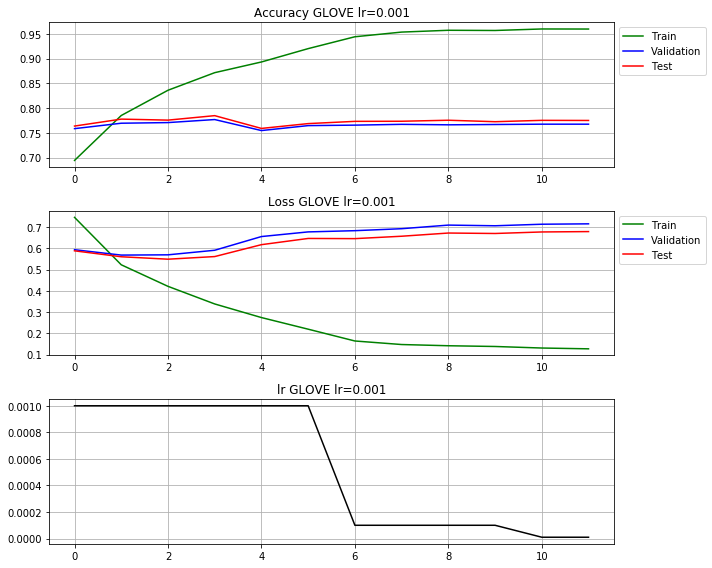

In [676]:
g001 = hist
plt2(g001, 'GLOVE lr=0.001')

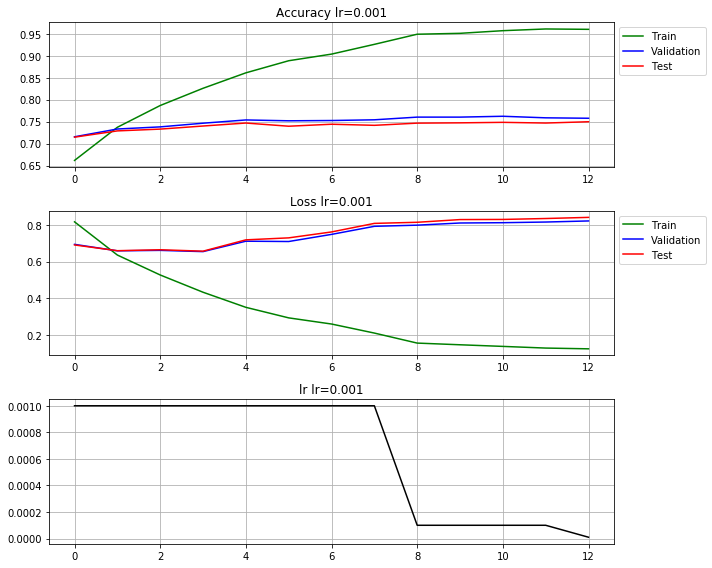

In [643]:
#h001 = hist
plt2(h001, 'lr=0.001')

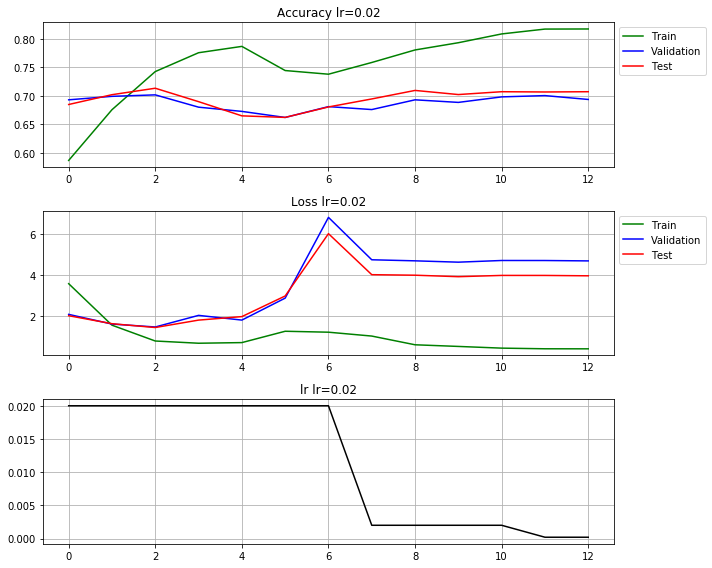

In [639]:
#h02 = hist
plt2(h02, 'lr=0.02')

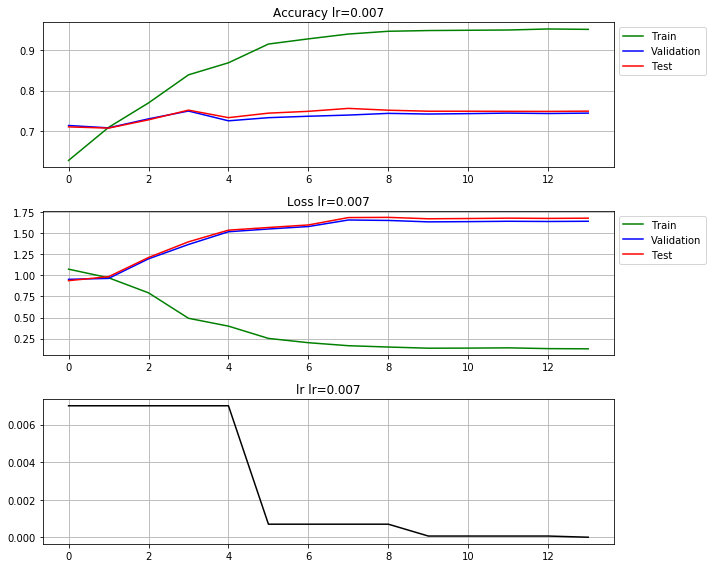

In [625]:
#h007 = hist
plt2(h007, 'lr=0.007')

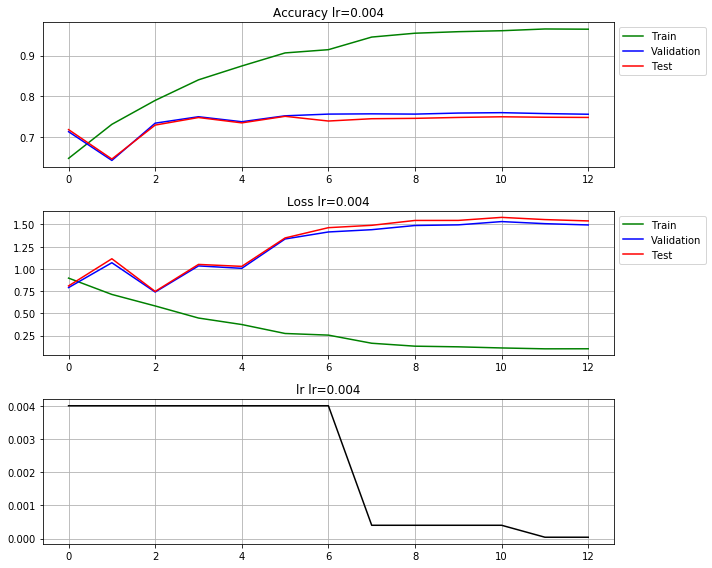

In [619]:
#h004 = hist
plt2(h004, 'lr=0.004')

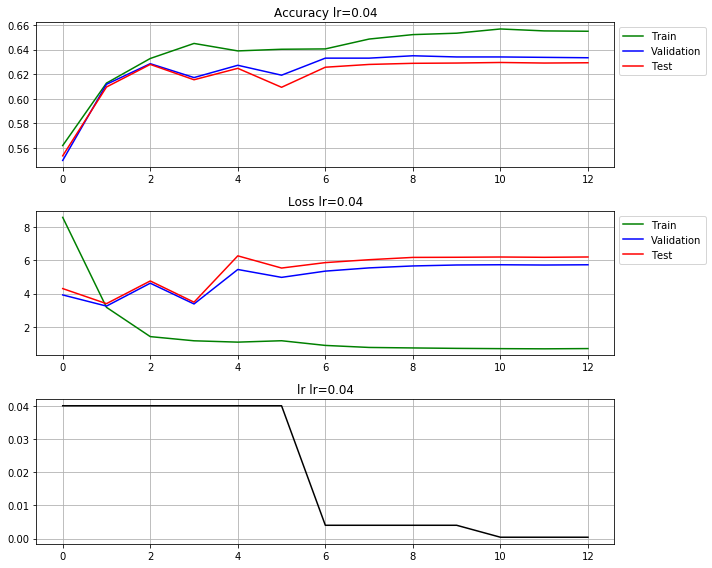

In [615]:
#h04 = hist
plt2(h04, 'lr=0.04')

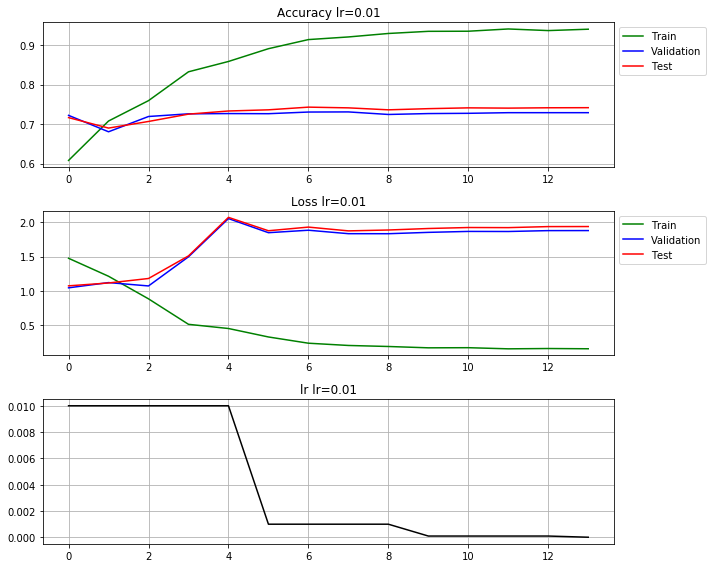

In [611]:
#h01 = hist
plt2(h01, 'lr=0.01')

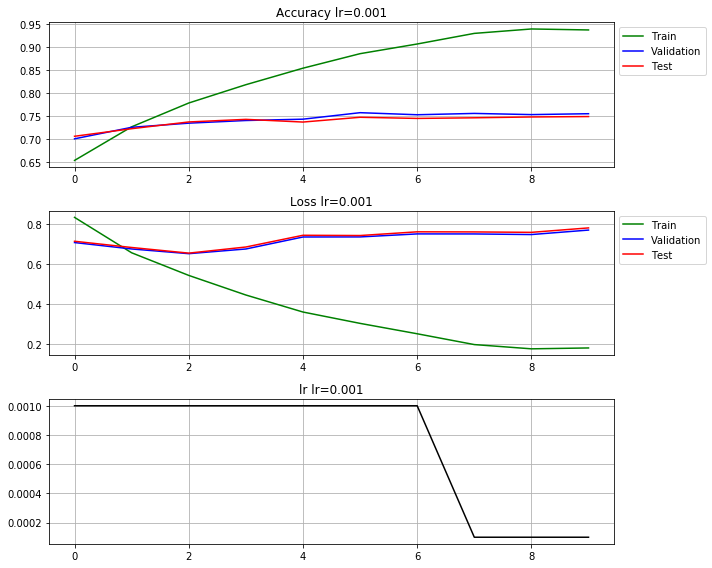

In [610]:
#h11 = hist
plt2(h11, 'lr=0.001')

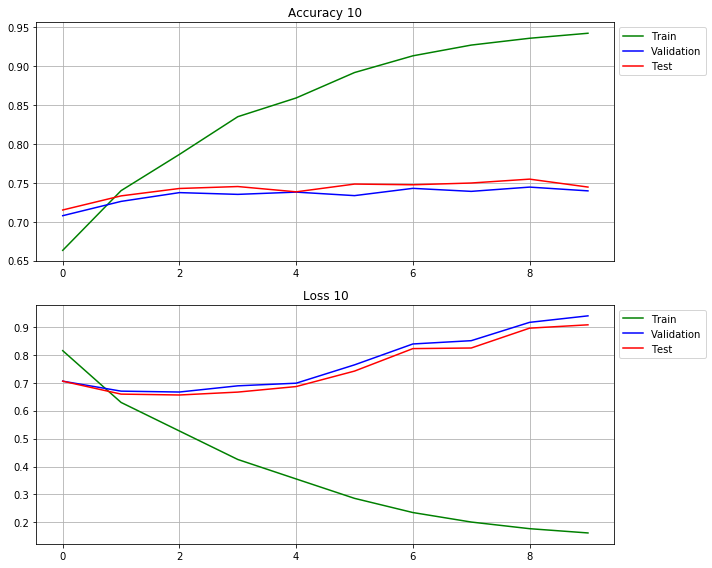

In [528]:
#h10 = hist
plt2(h10, '10')

In [579]:
optimizer.state_dict()['param_groups'][0]['lr']

1e-05

In [628]:
aa = np.array(h04.history["test_acc"])
i = np.argmax(aa)
acc = aa[i]
print(i, 'max test_acc=', acc)

10 max test_acc= 0.6295289855072463


In [80]:
def predict_sentiment(sentence, min_len=5):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [ ]:
predict_sentiment("This film is terrible")

In [81]:
predict_sentiment("This film is great")

NameError: name 'nlp' is not defined

100%|██████████████████████████████████████████████████▉| 399241/400000 [00:40<00:00, 18233.77it/s]

In [556]:
class History:
    def __init__(self):
        self.history = dict()
        self.history["acc"] = []
        self.history["val_acc"] = []
        self.history["test_acc"] = []
        self.history["loss"] = []
        self.history["val_loss"] = []
        self.history["test_loss"] = []
        self.history["lr"] = []
        
    def add_acc(self, acc, val_acc, test_acc):
        self.history["acc"].append(acc)
        self.history["val_acc"].append(val_acc)
        self.history["test_acc"].append(test_acc)
        
    def add_loss(self, loss, val_loss, test_loss):
        self.history["loss"].append(loss)
        self.history["val_loss"].append(val_loss)
        self.history["test_loss"].append(test_loss)
    
    def add_lr(self, lr):
        self.history["lr"].append(lr)        
        
h = History()
h.add_acc(1,1,1)
h.add_acc(2,2,2)
h.add_acc(3,3,3)
h.history["acc"]
        

[1, 2, 3]

In [557]:
def plt2(hist, tit):

    plt.subplot(311)
    plt.title("Accuracy " + tit)
    plt.plot(hist.history["acc"], color="g", label="Train")
    plt.plot(hist.history["val_acc"], color="b", label="Validation")
    plt.plot(hist.history["test_acc"], color="r", label="Test")
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    plt.grid()
    
    plt.subplot(312)
    plt.title("Loss " + tit)
    plt.plot(hist.history["loss"], color="g", label="Train")
    plt.plot(hist.history["val_loss"], color="b", label="Validation")
    plt.plot(hist.history["test_loss"], color="r", label="Test")
    plt.ticklabel_format(style='plain', axis='x')
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    plt.grid()
    
    plt.subplot(313)
    plt.title("lr " + tit)
    plt.plot(hist.history["lr"], color="k")
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    